<a href="https://colab.research.google.com/github/PeterSoojongHa/Verifying-Okuns-Law/blob/main/Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preface**

I have encountered two schools of thought on how students should decide their field of study: to choose what they enjoy learning, and to choose what they are best at.

Economics is the best of both worlds for me, as it offers elegantly simple laws that have been exciting to explore, as well as an opportunity to utilize my strengths in quantitative mathematics.

I believe that Okun's law (the linear relationship between the % growth of unemployment and the % growth of real GDP) is a perfect example of this duality, as the seemingly simple theory can actually be verified using math and real-world data. As a result, I have decided to create this program in hopes of demonstrating both my skillset and ethusiasm for economics.

**Introduction**

According to the [Encyclopedia Brittanica](https://www.britannica.com/biography/Arthur-M-Okun#ref1199250), Okun's law stipulates "that for every 3 percent rise in the rate of economic growth above the economy’s long-term potential growth rate, unemployment would decrease by 1 percent." Although the ratio between the rise of economic growth (real GDP) and the decrease of unemployment has been modified since then, the linear relationship between the two variables has stood the test of time.

This program will attempt to verify Okun's law by attempting to disprove its opposite, a hypothesis which we represent as H0. H0 claims that there is not a linear relationship between the change of unemployment and real GDP over time. In order to find the probability of H0 being true, this program will take real-world US unemployment data and RGDP (real GDP) data and organize it onto one dataframe. Then, the program will find the correlation coefficient of the two variables (a measure of how strong the two variables' linear relationship is) and use that value to find the p-value of H0 (the probability of such a strong correlation randomly occuring under the assumption that H0 is true, aka under the assumption that a linear relationship does not actually exist).

If the probability of H0 being true (which is represented by the p-value) is less than 0.05, the program can confidently conclude that the event that *1. the data has such a strong correlation* AND *2. H0 is true* is statistically significant. Here, an event being statistically significant means that it is extremely unlikely to occur.

Since the correlation of data has been quantitatively measured, it is assumed to be true. Then, a statistically significant event would indicate that our initial assumption that H0 is true is actually incorrect. As H0 is likely false, the program can now reject H0 and accept the opposite, or alternate, hypothesis (Ha). Here, Ha represents Okun's law, specifically the claim that there is a linear relationship between the change of unemployment and RGDP over time.

In [22]:
#Importing necessary modules
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [23]:
#The significance level was set as a variable so that it can be modified to yield more accurate results.
alpha_level = .05
print("This program verifies Okun's law using recent US unemployment and real GDP data.")
print("It will conduct a hypothesis test to determine whether there is a linear relationship between US % Unemployment growth and Real GDP growth.")
print(" ")
print("H0: There is no linear relationship between US % Unemployment growth and Real GDP growth.")
print("Ha: There is a linear relationship between US % Unemployment growth and Real GDP growth.")
print("an alpha level of %s will be used to accept or reject H0" % alpha_level)


This program verifies Okun's law using recent US unemployment and real GDP data.
It will conduct a hypothesis test to determine whether there is a linear relationship between US % Unemployment growth and Real GDP growth.
 
H0: There is no linear relationship between US % Unemployment growth and Real GDP growth.
Ha: There is a linear relationship between US % Unemployment growth and Real GDP growth.
an alpha level of 0.05 will be used to accept or reject H0


 
Extracting and organizing data...
Data organization complete.
Would you like to view the data as a table? (y/n)n
Would you like to view the data as a scatterplot? (y/n)y


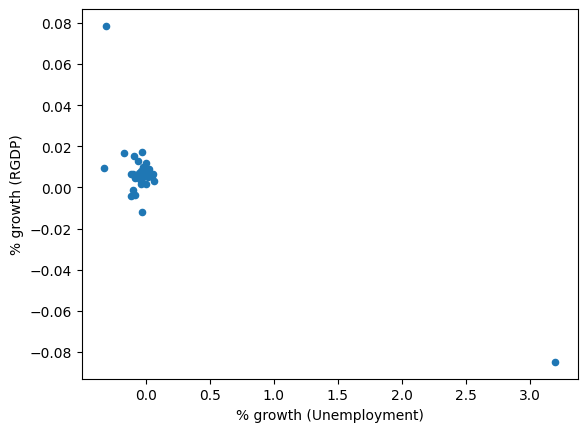

In [24]:
#DATA EXTRACTION
#Data was sourced from https://www.kaggle.com/datasets/pavankrishnanarne/us-real-gdp-quarterly-data-1947-present and https://data.bls.gov/timeseries/LNS14000000. (converted from .xlxs to .csv)
#In depth citations can be found on the "Works Cited" document.
print(" ")
print("Extracting and organizing data...")

#Imports the last 40 quarters (10 years) of US real GDP data, and calculates their % growth.
rgdp_data = pd.read_csv('https://raw.githubusercontent.com/PeterSoojongHa/Verifying-Okuns-Law/main/RGDP.csv')
rgdp_data["Prev RGDP"] = rgdp_data.value.shift(1)
rgdp_data["% growth (RGDP)"] = (rgdp_data["value"] / rgdp_data["Prev RGDP"] - 1)
rgdp_data = rgdp_data.drop(rgdp_data.index[:266])
rgdp_data = rgdp_data.reset_index(drop=True)
rgdp_data.drop(columns=["value", "Prev RGDP"], inplace = True)

#Imports/derives the last 10 quarters (10 years) of US unemployment data (converts monthly -> quarterly).
unemp_data = pd.read_csv('https://raw.githubusercontent.com/PeterSoojongHa/Verifying-Okuns-Law/main/Unemployment.csv')
unemp_data = unemp_data.drop(unemp_data.index[:10])
unemp_data.columns = unemp_data.iloc[0]
unemp_data = unemp_data.rename_axis("Index", axis=0)
unemp_data = unemp_data.drop(unemp_data.index[0])
unemp_data = unemp_data.reset_index(drop=True)
unemp_data.drop(columns=['Feb','Mar', 'May', 'Jun', 'Aug', 'Sep', 'Nov', 'Dec'], inplace=True)

#Organize US unemployment data in the same format as US real gdp data and calculates their % growth
tp_unemp_data = unemp_data.transpose()
tp_unemp_data.columns = tp_unemp_data.iloc[0]
form_unemp_data = pd.concat([tp_unemp_data, tp_unemp_data.T.stack().reset_index(name='percent_unemployed')['percent_unemployed']], axis=1)
form_unemp_data.drop(columns=['2013','2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'], inplace=True)
form_unemp_data = form_unemp_data.drop(form_unemp_data.index[:7])
form_unemp_data = form_unemp_data.drop(form_unemp_data.index[3:70:5])
form_unemp_data = form_unemp_data.reset_index(drop=True)
form_unemp_data["Prev unemp"] = form_unemp_data.percent_unemployed.shift(1)
form_unemp_data = form_unemp_data.drop(form_unemp_data.index[0])
form_unemp_data['Prev unemp'] = form_unemp_data['Prev unemp'].astype(float)
form_unemp_data['percent_unemployed'] = form_unemp_data['percent_unemployed'].astype(float)
form_unemp_data["% growth (Unemployment)"] = (form_unemp_data["percent_unemployed"] / form_unemp_data["Prev unemp"] - 1)
form_unemp_data.drop(columns=["percent_unemployed", "Prev unemp"], inplace = True)
form_unemp_data = form_unemp_data.reset_index(drop=True)

#Combine US RGDP and unemployment data onto one dataframe
df = rgdp_data.join(form_unemp_data)
df.set_index('date')
df.drop(columns=["date"], inplace = True)
print("Data organization complete.")

#Gives the user the options to view the data as a table, a scatterplot, both, or neither.

while True:
    prompt1=input('Would you like to view the data as a table? (y/n)').lower()

    if prompt1 == 'y':
       print(df)
       break
    elif prompt1 == 'n':
       break
    else:
       print('please input y (yes) or n (no)')

while True:
    prompt2=input('Would you like to view the data as a scatterplot? (y/n)').lower()

    if prompt2 == 'y':
       df.plot.scatter(x = '% growth (Unemployment)', y = '% growth (RGDP)')
       plt.show()
       break
    elif prompt2 == 'n':
       break
    else:
       print('please input y (yes) or n (no)')


In [25]:
#DATA ANALYSIS
print(" ")
print("Proceeding to data analysis...")

#Finding the correlation coefficient (r) and the p_value
correlation_coeff = pearsonr(df['% growth (RGDP)'], df['% growth (Unemployment)'])[0]
p_val = pearsonr(df['% growth (RGDP)'], df['% growth (Unemployment)'])[1]
print("The value of r (the correlation coefficient) is %s." % correlation_coeff)
print("The p-value (the probability of the data set existing assuming that H0 is true) is %s" % p_val)

 
Proceeding to data analysis...
The value of r (the correlation coefficient) is -0.7995370283623032.
The p-value (the probability of the data set existing assuming that H0 is true) is 6.125223749668172e-10


In [26]:
#CONCLUSIONS
#Although the datasets that are currently in use always rejects H0 and successfully verifies Okun's law, alternative conclusions are available in the case of other datasets being in use.
print(" ")
print("The conclusions are as follows:")
if correlation_coeff < -.75:
    print("As the correlation coefficient is near -1, it indicates a strong, negative, linear relationship between the change in RGDP and Unemployment over time.")
elif correlation_coeff >.75:
    print("As the correlation coefficient is near +1, it indicates a strong, positive, linear relationship between the change in RGDP and Unemployment over time.")
else:
    print("As the correlation coefficient is not significantly near -1 or +1, it does not indicate a clear linear relationship between the change in RGDP and Unemployment over time.")
if p_val <= alpha_level:
    print("As the p_value (%s) is less than or equal to the alpha level (%s), we succeed in rejecting H0." % (p_val, alpha_level))
    print("There is enough evidence to suggest a linear relationship between % Unemployment growth and Real GDP Growth in the US, which successfully verifies Okun's law")
else:
    print("As the p_value (%s) is greater than the alpha level(%s), we fail to reject H0." % (p_val, alpha_level))
    print("There is not enough evidence to suggest a linear relationship between % Unemployment growth and Real GDP Growth in the US, which fails to verify Okun's law")


 
The conclusions are as follows:
As the correlation coefficient is near -1, it indicates a strong, negative, linear relationship between the change in RGDP and Unemployment over time.
As the p_value (6.125223749668172e-10) is less than or equal to the alpha level (0.05), we succeed in rejecting H0.
There is enough evidence to suggest a linear relationship between % Unemployment growth and Real GDP Growth in the US, which successfully verifies Okun's law


**Conclusion & Reflections**

As expected in the introduction, an analysis of the correlation between the change in US RGDP data and US unemployment data has indicated a strong correlation coefficient (-0.7995370283623032) and a very low p-value (6.125223749668172e-10). As the correlation coefficient always ranges between -1 and 1 and stronger correlations are indicated by correlation coefficients that are farther away from 0, a correlation coefficient of -0.7995370283623032 is said to indicate a strong negative correlation. For reference, an absolute value greater than .7 is a commonly accepted indication that a correlation coefficient is strong, and our value of |-0.7995370283623032| = .7995370283623032 passes this test. Additionally, the p-value (probability of such a strong correlation occuring if there is no actual linear relation) is lower than the widely accepted significance level of .05, meaning that H0 is statistically significant (unlikely to occur).

We can then reject H0 (the claim that there is no linear relationship between US % Unemployment growth and Real GDP growth), and by default, Ha (Okun's law) is accepted. We have now successfully verified Okun's law through real-world data.

However, there are many limitations to this verification. As I could only find quarterly data for US RGDP, I had to throw out 1/4 of the montly data for US Unemployment. The verification process would have been much more accurate if I had access to monthly US RGDP data, and of course, access to weekly or daily data would have made the verification even more accurate. Also, as I was unable to find a more credible data source for monthly or quarterly US RGDP data, I decided to use the somewhat untrustworthy Kaggle source. Although I have verified that the % RGDP growth data derived from the Kaggle source matches the few pieces of % RGDP growth data available on the Bureau of Economic Analysis website, the lack of credibility of the Kaggle source is definitely an issue that I hope to avoid in future projects.

Additionally, I chose to analyze the past 10 years' worth of data on the US economy under the assumption that economic cycles typically last shorter than 10 years. Although I believe that the data covered multiple economic cycles, a wider range of dates may have allowed the verification process to be even more precise. Finally, there were two outlier points (as evident on the scatterplot), and in hindsight, it may have been good practice to eliminate them from the dataset.